In [72]:
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import datetime
import pytz
import matplotlib.pyplot as plt
import preprocessing as prep
from collections import namedtuple
from bb_binary import FrameContainer, Repository, load_frame_container
import numpy as np
import numpy.ma as npma
import datetime
import csv
import seaborn as sns
from collections import Counter
sns.set_context("paper")
import hatching as ht

In [36]:
%matplotlib inline

In [437]:
start = "2016-07-26T16:00:00Z"
start_dt = datetime.datetime.strptime(start, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=pytz.UTC)
start_ts = start_dt.timestamp()
end_dt = start_dt + datetime.timedelta(minutes=60)
end_ts = end_dt.timestamp()

In [438]:
df0 = prep.getDF("/mnt/data2016/",start_ts, end_ts, 0)
df1 = prep.getDF("/mnt/data2016/",start_ts, end_ts, 1)
df2 = prep.getDF("/mnt/data2016/",start_ts, end_ts, 2)
df3 = prep.getDF("/mnt/data2016/",start_ts, end_ts, 3)

In [439]:
data2 = pd.concat([df0,df1,df2,df3])

In [161]:
data = pd.concat([df0,df1,df2,df3])

In [162]:
data.head(3)

,idx,xpos,ypos,radius,zRotation,decodedId,frame_idx,timestamp,cam_id,fc_id
0,0,51,1337,22.927212,-0.436176,"[255, 255, 0, 255, 0, 0, 254, 255, 255, 0, 255...",0,1.469549e+09,0,10487780367802891005
1,1,163,1538,22.708023,0.595369,"[255, 255, 255, 255, 0, 0, 0, 254, 255, 255, 2...",0,1.469549e+09,0,10487780367802891005
2,2,189,2626,23.293472,0.364826,"[126, 134, 144, 71, 92, 248, 21, 15, 8, 130, 1...",0,1.469549e+09,0,10487780367802891005


In [163]:
data = prep.calcIds(data, 0, 2016)

In [164]:
total = data.shape[0]
remaining = []
for i in np.arange(0,1.01, 0.01):
    df = data[data.confidence >= i]
    remaining.append({'conf': i*100, 'rest': df.shape[0], 'restP': df.shape[0]/total*100})

In [165]:
plotData = DataFrame(remaining)

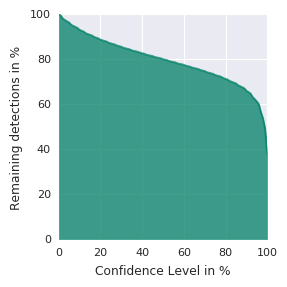

In [166]:
fig, ax = plt.subplots()
ax = plotData.plot(x='conf', y='restP', kind='area', alpha=0.75, ax=ax, colormap='summer', legend=False)
#ax.set_title('Remaining Data & Confidence Level')
ax.set_xlabel('Confidence Level in %')
ax.set_ylabel('Remaining detections in %')
fig.set_size_inches(5.91553/2,3)
plt.tight_layout()
plt.savefig('confVSamount.pdf')

In [167]:
total = 4096
remainingIDs = []
for i in np.arange(0,1.01, 0.01):
    df = data[data.confidence >= i]
    ids = len(df.id.unique())
    
    remainingIDs.append({'conf': i*100, 'rest': ids, 'restP': ids/total*100})

In [168]:
plotDataIDs = DataFrame(remainingIDs)

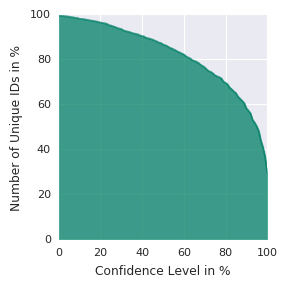

In [169]:
fig, ax = plt.subplots()
ax = plotDataIDs.plot(x='conf', y='restP', kind='area', alpha=0.75, ax=ax, colormap='summer', legend=False)
#ax.set_title('Unique IDs & Confidence Level')
ax.set_xlabel('Confidence Level in %')
ax.set_ylabel('Number of Unique IDs in %')
fig.set_size_inches(5.91553/2,3)
plt.tight_layout()
plt.savefig('confVSids.pdf')

In [170]:
aa = ht.get_all_bees_age(start_dt)

In [171]:
data['age'] = data.id.apply(lambda x: aa.iloc[x].age)

In [172]:
data.head()

,idx,xpos,ypos,radius,zRotation,frame_idx,timestamp,cam_id,fc_id,confidence,id,age
0,0,51,1337,22.927212,-0.436176,0,1.469549e+09,0,10487780367802891005,0.992157,3387,15
1,1,163,1538,22.708023,0.595369,0,1.469549e+09,0,10487780367802891005,0.992157,3870,5
2,2,189,2626,23.293472,0.364826,0,1.469549e+09,0,10487780367802891005,0.011765,1607,4
3,3,202,924,22.790953,0.147058,0,1.469549e+09,0,10487780367802891005,0.992157,1854,5
4,4,201,1990,23.085573,0.218766,0,1.469549e+09,0,10487780367802891005,0.050980,541,-100


In [173]:
remainingDetAge = []
for i in np.arange(0,1.01, 0.01):
    df = data[data.confidence >= i]
    c = i*100
    numDet = df.shape[0]
    wrongs = df[df.age < 0].shape[0]
    remainingDetAge.append({'conf': c, 'detections': numDet, 'wrongs': wrongs, 'wrongsP': (wrongs*2)/numDet*100})

In [174]:
plotDataDetAge = DataFrame(remainingDetAge)

In [187]:
plotDataDetAge.tail()

,conf,detections,wrongs,wrongsP
96,96.0,320361,6827,4.262067
97,97.0,301628,5634,3.735727
98,98.0,286689,4893,3.413455
99,99.0,262560,4003,3.049208
100,100.0,203955,2508,2.459366


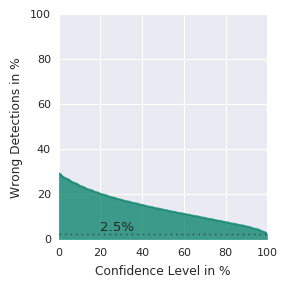

In [189]:
fig, ax = plt.subplots()
ax = plotDataDetAge.plot(x='conf', y='wrongsP', kind='area', alpha=0.75, ax=ax, colormap='summer', legend=False, ylim=(0,100))
#ax.set_title('Unique IDs & Confidence Level')
ax.set_xlabel('Confidence Level in %')
ax.set_ylabel('Wrong Detections in %')

plt.axhline(2.456, color='0.25', linestyle='dotted', linewidth=1)
plt.text(20,4,'2.5%',rotation=0)
    
fig.set_size_inches(5.91553/2,3)
plt.tight_layout()
plt.savefig('confVSdetquality.pdf')

In [176]:
data.head(2)

,idx,xpos,ypos,radius,zRotation,frame_idx,timestamp,cam_id,fc_id,confidence,id,age
0,0,51,1337,22.927212,-0.436176,0,1.469549e+09,0,10487780367802891005,0.992157,3387,15
1,1,163,1538,22.708023,0.595369,0,1.469549e+09,0,10487780367802891005,0.992157,3870,5


In [177]:
total = 4096
remainingIDsAge = []

for i in np.arange(0,1.01, 0.01):
    df = data[data.confidence >= i]
    ids = DataFrame(df.id.unique(), columns=['id'])
    ids['age'] = ids.id.apply(lambda x: aa.iloc[x].age)
    
    numIDs = ids.shape[0]
    wrongs = ids[ids.age < 0].shape[0]
    
    remainingIDsAge.append({'conf': i*100, 'IDs': numIDs, 'wrongs': wrongs, 'wrongsP':  (wrongs)/numIDs*100})

In [178]:
plotDataIDsAge = DataFrame(remainingIDsAge)

In [186]:
plotDataIDsAge.tail()

,IDs,conf,wrongs,wrongsP
96,1962,96.0,951,48.470948
97,1790,97.0,825,46.089385
98,1670,98.0,733,43.892216
99,1499,99.0,600,40.026684
100,1217,100.0,368,30.238291


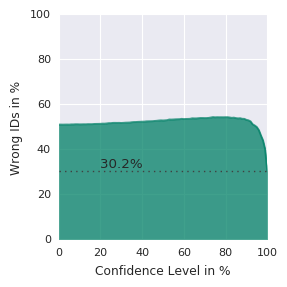

In [190]:
fig, ax = plt.subplots()
ax = plotDataIDsAge.plot(x='conf', y='wrongsP', kind='area', alpha=0.75, ax=ax, colormap='summer', legend=False, ylim=(0,100), xlim=(0,100))
#ax.set_title('Unique IDs & Confidence Level')
ax.set_xlabel('Confidence Level in %')
ax.set_ylabel('Wrong IDs in %')

plt.axhline(30.24, color='0.25', linestyle='dotted', linewidth=1)
plt.text(20,32,'30.2%',rotation=0)

fig.set_size_inches(5.91553/2,3)
plt.tight_layout()
plt.savefig('confVSidsquality.pdf')

In [435]:
dffrequency.head(2)

,id,frequency,age
0,7,3,-100
1,8,69,1


In [236]:
dffrequency = DataFrame(data[data.confidence >= 0.95].groupby(by='id').size(), columns=['frequency']).reset_index()
dffrequency['age'] = dffrequency.id.apply(lambda x: aa.iloc[x].age)

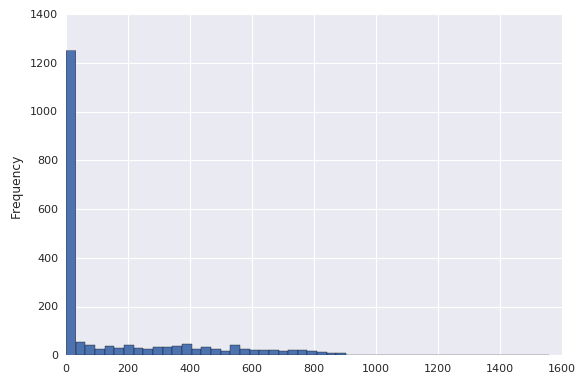

In [436]:
dffrequency.frequency.plot.hist(bins=50)

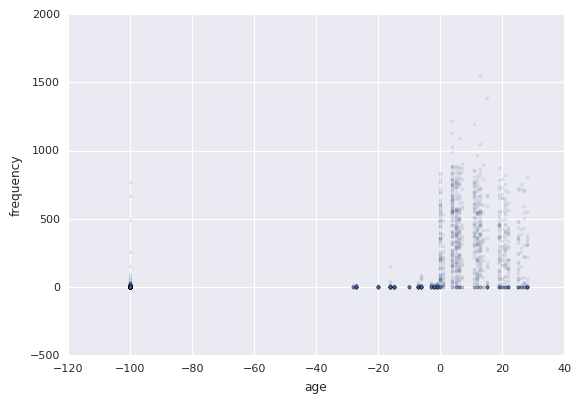

In [237]:
dffrequency.plot.scatter(x='age', y='frequency', s=5, alpha=0.1)

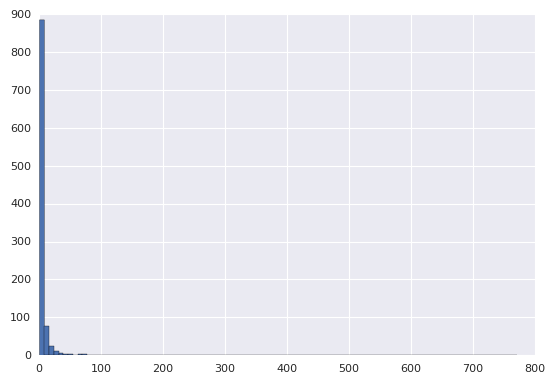

In [238]:
dffrequency[dffrequency.age < 0].frequency.hist(bins=100)#mean()

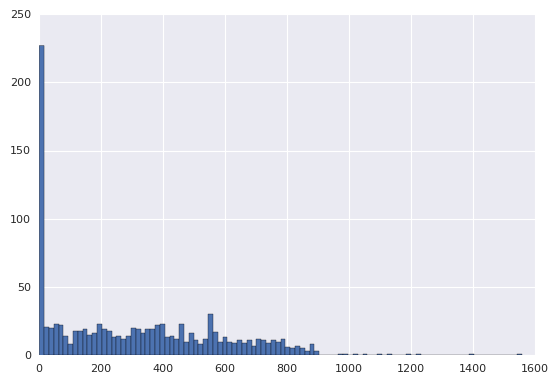

In [239]:
dffrequency[dffrequency.age >= 0].frequency.hist(bins=100) #mean()

In [219]:
dffrequency.frequency.mean()

159.34827082318557

In [220]:
310.5/7.2

43.125

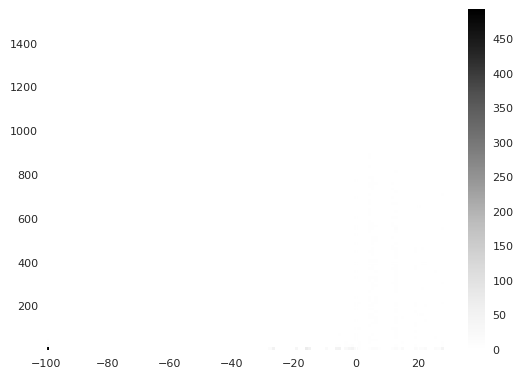

In [221]:
H, xedges, yedeges, im = plt.hist2d(dffrequency.age,dffrequency.frequency,bins=[120,120])
plt.colorbar()

# Average Number of Gaps per Bee Series depending on Confidence Level

In [240]:
data.head()

,idx,xpos,ypos,radius,zRotation,frame_idx,timestamp,cam_id,fc_id,confidence,id,age
0,0,51,1337,22.927212,-0.436176,0,1.469549e+09,0,10487780367802891005,0.992157,3387,15
1,1,163,1538,22.708023,0.595369,0,1.469549e+09,0,10487780367802891005,0.992157,3870,5
2,2,189,2626,23.293472,0.364826,0,1.469549e+09,0,10487780367802891005,0.011765,1607,4
3,3,202,924,22.790953,0.147058,0,1.469549e+09,0,10487780367802891005,0.992157,1854,5
4,4,201,1990,23.085573,0.218766,0,1.469549e+09,0,10487780367802891005,0.050980,541,-100


In [320]:
def get_gaps_length(kette):
    kette = kette.apply(str)
    s = kette.str.cat(sep='')
    #s = s.strip("0")
    ss = s.split('1')
    return [len(x) for x in ss if len(x) > 0]

In [321]:
def get_num_of_gaps(kette):
    kette = kette.apply(str)
    s = kette.str.cat(sep='')
    #s = s.strip("0")
    ss = s.split('1')
    return len([len(x) for x in ss if len(x) > 0])

In [392]:
statGapS = []
for i in np.arange(0,1.01, 0.01)[[0,10,20,30,40,50,60,70,80,85,90,91,92,93,94,95,96,97,98,99,100]]:
    dd = data[data.confidence >= i]
    dft = prep.df_to_timeseries(dd)
    gapsLen = dft.apply(get_gaps_length, axis=1)
    flattened = [n for elem in gapsLen for n in elem]
    sL = Series(flattened)
 
    gapsNum = dft.apply(get_num_of_gaps, axis=1)
    s = Series(gapsNum)
    
    s0 = dft.shape[1] - Series(dft.sum(axis=1))
    
    statGapS.append({'conf': i, 'LenMean': sL.mean(), 'LenMedian': sL.median(), 'NumMean': s.mean(), 'NumMedian': s.median(),'total': dft.shape[0], \
                    'total0': s0.sum(), 's0mean': s0.mean(), 's0median': s0.median()})

In [393]:
dfGAPS = DataFrame(statGapS)
dfGAPS.conf *= 100

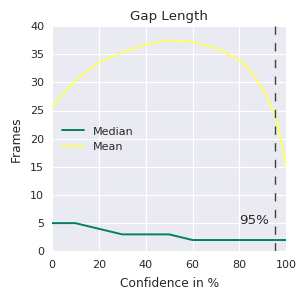

In [428]:
fig, ax = plt.subplots()
dfGAPS.plot(x="conf", y=["LenMedian", "LenMean"], colormap="summer", ax=ax)
fig.set_size_inches(5.91553/2,3)
plt.tight_layout()
ax.set_title("Gap Length")
ax.set_ylabel("Frames")
ax.set_xlabel("Confidence in %")
ax.legend(["Median", "Mean"], loc=0)
plt.axvline(95, color='0.25', linestyle='dashed', linewidth=1)
plt.text(80,5,'95%',rotation=0)
plt.savefig('gaplen.pdf')

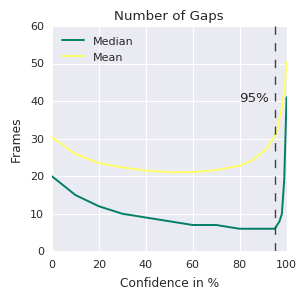

In [425]:
fig, ax = plt.subplots()
dfGAPS.plot(x="conf", y=["NumMedian", "NumMean"], colormap="summer",ax=ax)
fig.set_size_inches(5.91553/2,3)
plt.tight_layout()
ax.set_title("Number of Gaps")
ax.set_ylabel("Frames")
ax.set_xlabel("Confidence in %")
ax.legend(["Median", "Mean"], loc=0)
plt.axvline(95, color='0.25', linestyle='dashed', linewidth=1)
plt.text(80,40,'95%',rotation=0)
plt.savefig('numgaps.pdf')

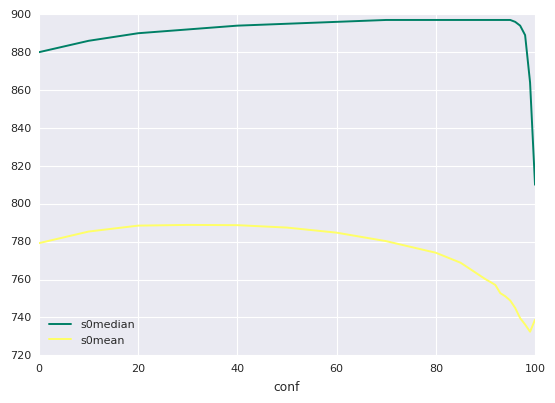

In [429]:
dfGAPS.plot(x="conf", y=["s0median", "s0mean"], colormap="summer")

In [368]:
testdf = DataFrame([[1,2,3],[3,4,5],[3,4,5]])

In [369]:
testdf

,0,1,2
0,1,2,3
1,3,4,5
2,3,4,5


In [371]:
testdf.sum(axis=1)

0     6
1    12
2    12
dtype: int64

# Histogramm: Frequency of Detection per ID: conf = 95

In [430]:
data95 = data[data.confidence >= 0.95]

In [432]:
data95Stat = data95.groupby(by='id').size()

In [433]:
data95Stat

id
7         3
8        69
10      171
11        3
12      154
13        1
14        2
16       92
18      393
19        1
20      561
22        2
23      575
24        1
26        2
27      297
28        1
29       15
30      763
31        9
32      536
33        2
34        2
36      533
38        1
41        2
42        1
44        4
46        1
48       57
       ... 
4052    176
4053      2
4055    632
4060     13
4061    720
4062      5
4063      2
4065    285
4066    163
4067      8
4068    547
4069      1
4071    729
4072      1
4073      2
4074      1
4075      4
4076      2
4077      4
4078    287
4079      2
4081      1
4083      2
4084      1
4085    902
4086    672
4092    535
4093      3
4094      1
4095      2
dtype: int64